# A Tutorial of QDock

  QDock is a python package encoding pose sampling in molecular docking for quantum conputers. In brief, it translates pose sampling into QC-intepretable QUBO models. There are two methods in QDock package, including "Grid Point Matching" and "Feature Atom Matching". Grid Point Matching is close to the sampling performance of Glide SP, while Feature Atom Matching is computationally more efficient. A brief illustration of both methos are given below. QDock also integrates a QC-simulator to solve the sampling problem.

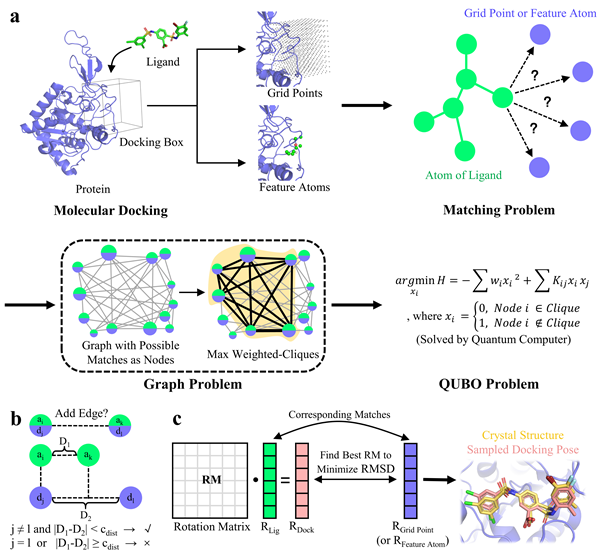

Recommended Configuration<p>
Python   3.9<br>
PyQUBO   1.2.0<br>
Prody    2.2.0<br>
Numpy    1.23.4<br>
Scipy    1.7.1<br>
<br>
AutoDockFR should be downloaded and installed. Its "bin" path should be added to enviromental variables. AutoDockFR is at https://ccsb.scripps.edu/adfr/downloads/ 


Some Preparations

In [1]:
import os
here = os.getcwd()
if not os.path.exists("workdir_fam"):
    os.mkdir("workdir_fam")
if not os.path.exists("workdir_gpm"):
    os.mkdir("workdir_gpm")

Let's begin with Grid point matching. Run below. 

In [2]:
from QDock.GridPointMatching.qdock import GPMDock
from QDock.FeatureAtomMatching.qdock import FAMDock
os.chdir("%s/workdir_fam"%(here))
fam = FAMDock()

1, Load protein file (in PDB format)

In [3]:
#fam.make_receptor("./data/1y6r_protein.pdb", "./workdir_fam/")
fam.make_receptor("../data/1y6r_protein.pdb")

adding gasteiger charges to peptide


2, Load ligand files to be docked

In [4]:
import shutil
ligand_li = [
  "1y6r_ligand.mol2",
  "2vkm_ligand.mol2",
  "3dxg_ligand.mol2",
  "2iwx_ligand.mol2",   
]

for i in ligand_li:
    shutil.copy("%s/%s"%("../data",i),"./%s"%(i))
#Well, it is a bug in AutoDockFR, that only ligand file at current dir could be processed.
    
fam.make_ligand(ligand_li)

FileNotFoundError: [Errno 2] No such file or directory: '../data/1y6r_ligand.mol2'

3, Create the doxking box. There are two ways to create the docking box, either by the position of a ligand or give the corrdiante and length of the docking box.Here, the parameter "grid length" suggests the degree to discrete docking box. It is recomended to use 1.0 for "Feature Atom Matching" and 2.0 for "Grid Point Matching".

In [ ]:
#Via original ligand
fam.make_box_ligand("data/1y6r_ligand.mol2",grid_length=1.0)

#Via manual input of docking box(coordinates of the center and length in x,y,z dimension)
#fam.make_box_input(x=56.217,y=73.499,z=20.476,dx=10,dy=10,dz=10,grid_length=1.0)

4,Docking. There are two docking modes. You could either dock a single ligand in thr ligand list made in step 2, or dock all ligandsin the ligand list. 

4.1, Dock a single ligand.<p> 
Explanation of parameters:<br>
    ligand: The ligand to be docked.<br>
    edge_cutoff: c_dist, the tolerance of geometry. 1.870 is recommended for Feature Atom Matching and 2.162 is recommended for Grid Point Matching<br>
    K_dist: Lagrange parameter maintaining geometry. 2.261 is recommended for Feature Atom Matching and 0.405 is recommended for Grid Point Matching<br>
    K_mono:  Lagrange parameter controling unique of matching 11.479 is recommended for Feature Atom Matching and 25.090 is recommended for Grid Point Matching<br>
    save_qubo: True (defalut) for saving the QUBO matrix. You could sent it to QCs.<br>
    sim_dock: True (default) to solve QUBO with a pyqubo simulator. If you switch it to False, then the function would stop when QUBO matrix is saved.<br>
    n_pose: number of poses to be sampled by simulator. default=30.<br>
    save_match: True (defalut) for saving the matching result.<br>
    save_pose: True (defalut) for saving the sampled poses (pdb file).<br>

In [ ]:
poses1 = fam.indiv_dock(ligand=fam.ligands[0], edge_cutoff=1.870, K_dist=2.261, K_mono=11.479, n_pos=30, 
                       save_qubo=True,sim_dock=True,save_match=True,save_pose=True)
#numpy array

4.2, Dock multiple ligands. Parameters are the same as indiv_dock, while the ligand does not require an assignment, All ligand in the ligand list will be docked. 

In [ ]:
poses2 = fam.dock(edge_cutoff=1.870, K_dist=2.261, K_mono=11.479, n_pos=30, 
                 save_qubo=True,sim_dock=True,save_match=True,save_pose=True)
#python list

5, Results

5.1, Poses. A numpy array containing coordinates of sampled poses.

In [ ]:
print(type(poses1))
print(poses1.shape)
print(poses1[0])
print(type(poses2))
print(len(poses2))
print(poses2[1].shape)

5.2, QUBO. A QUBO matrix (a python dict) saved in npy file. The QUBO matrix could be solved by QCs like D-WAVE amd CIM.

In [ ]:
import numpy as np
qubo = np.load("QUBOs/1y6r_ligand.npy",allow_pickle=True).item()
print(list(qubo.keys())[0:10])
print(qubo[list(qubo.keys())[0]])

5.3, Results of sampling. (Red: Sampled Poses; Blue: Crystal Pose)
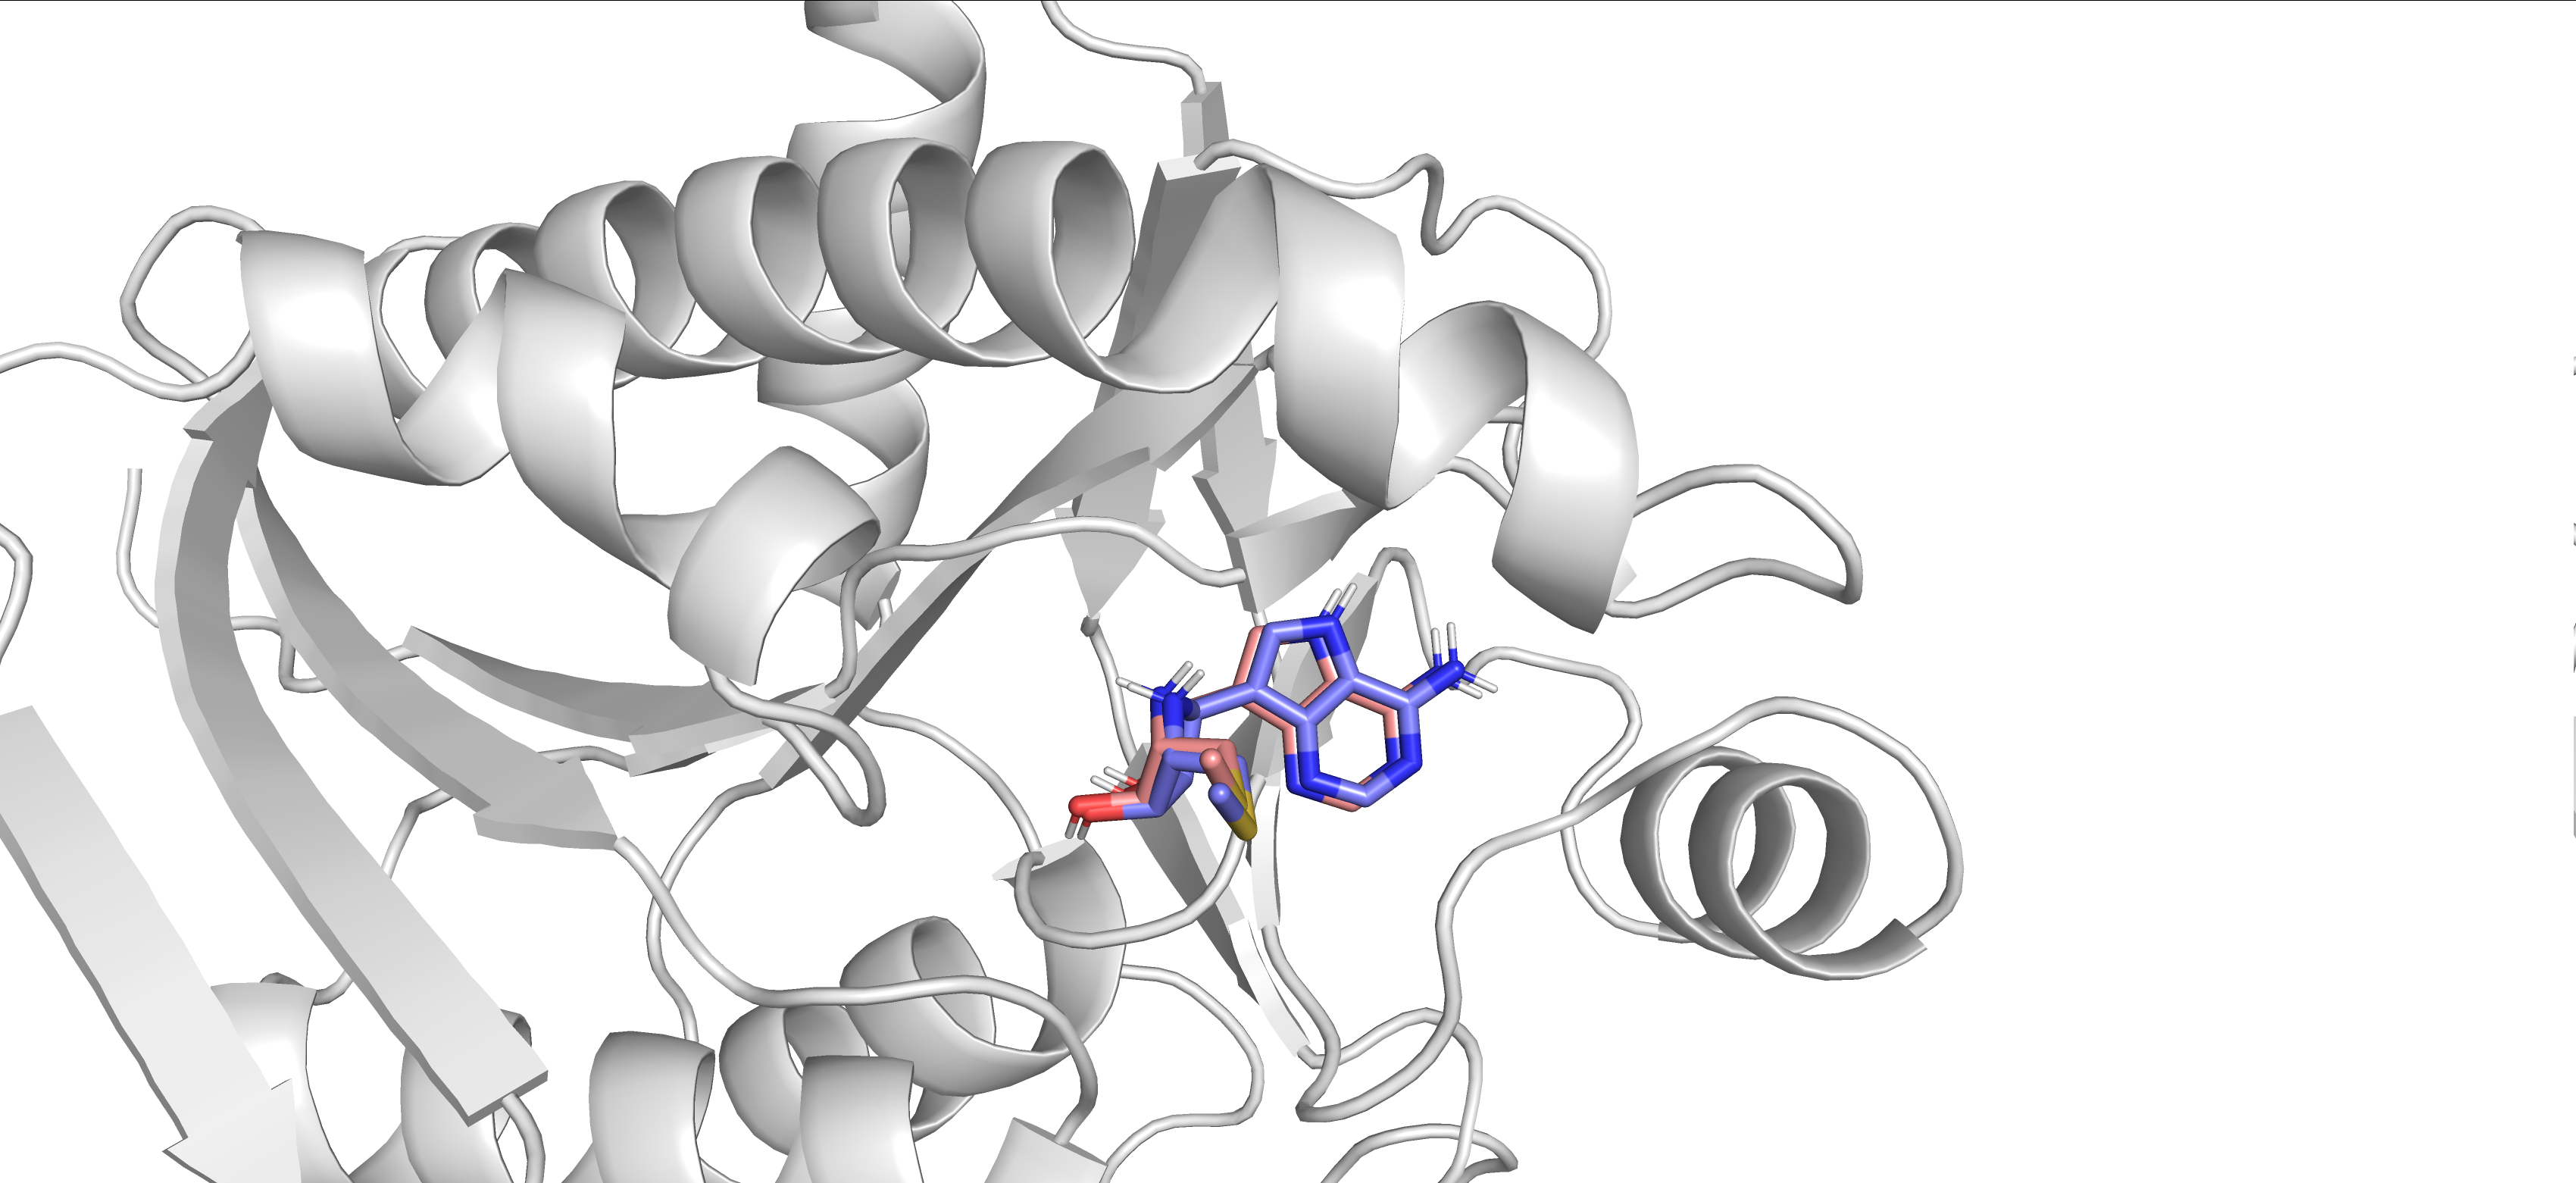
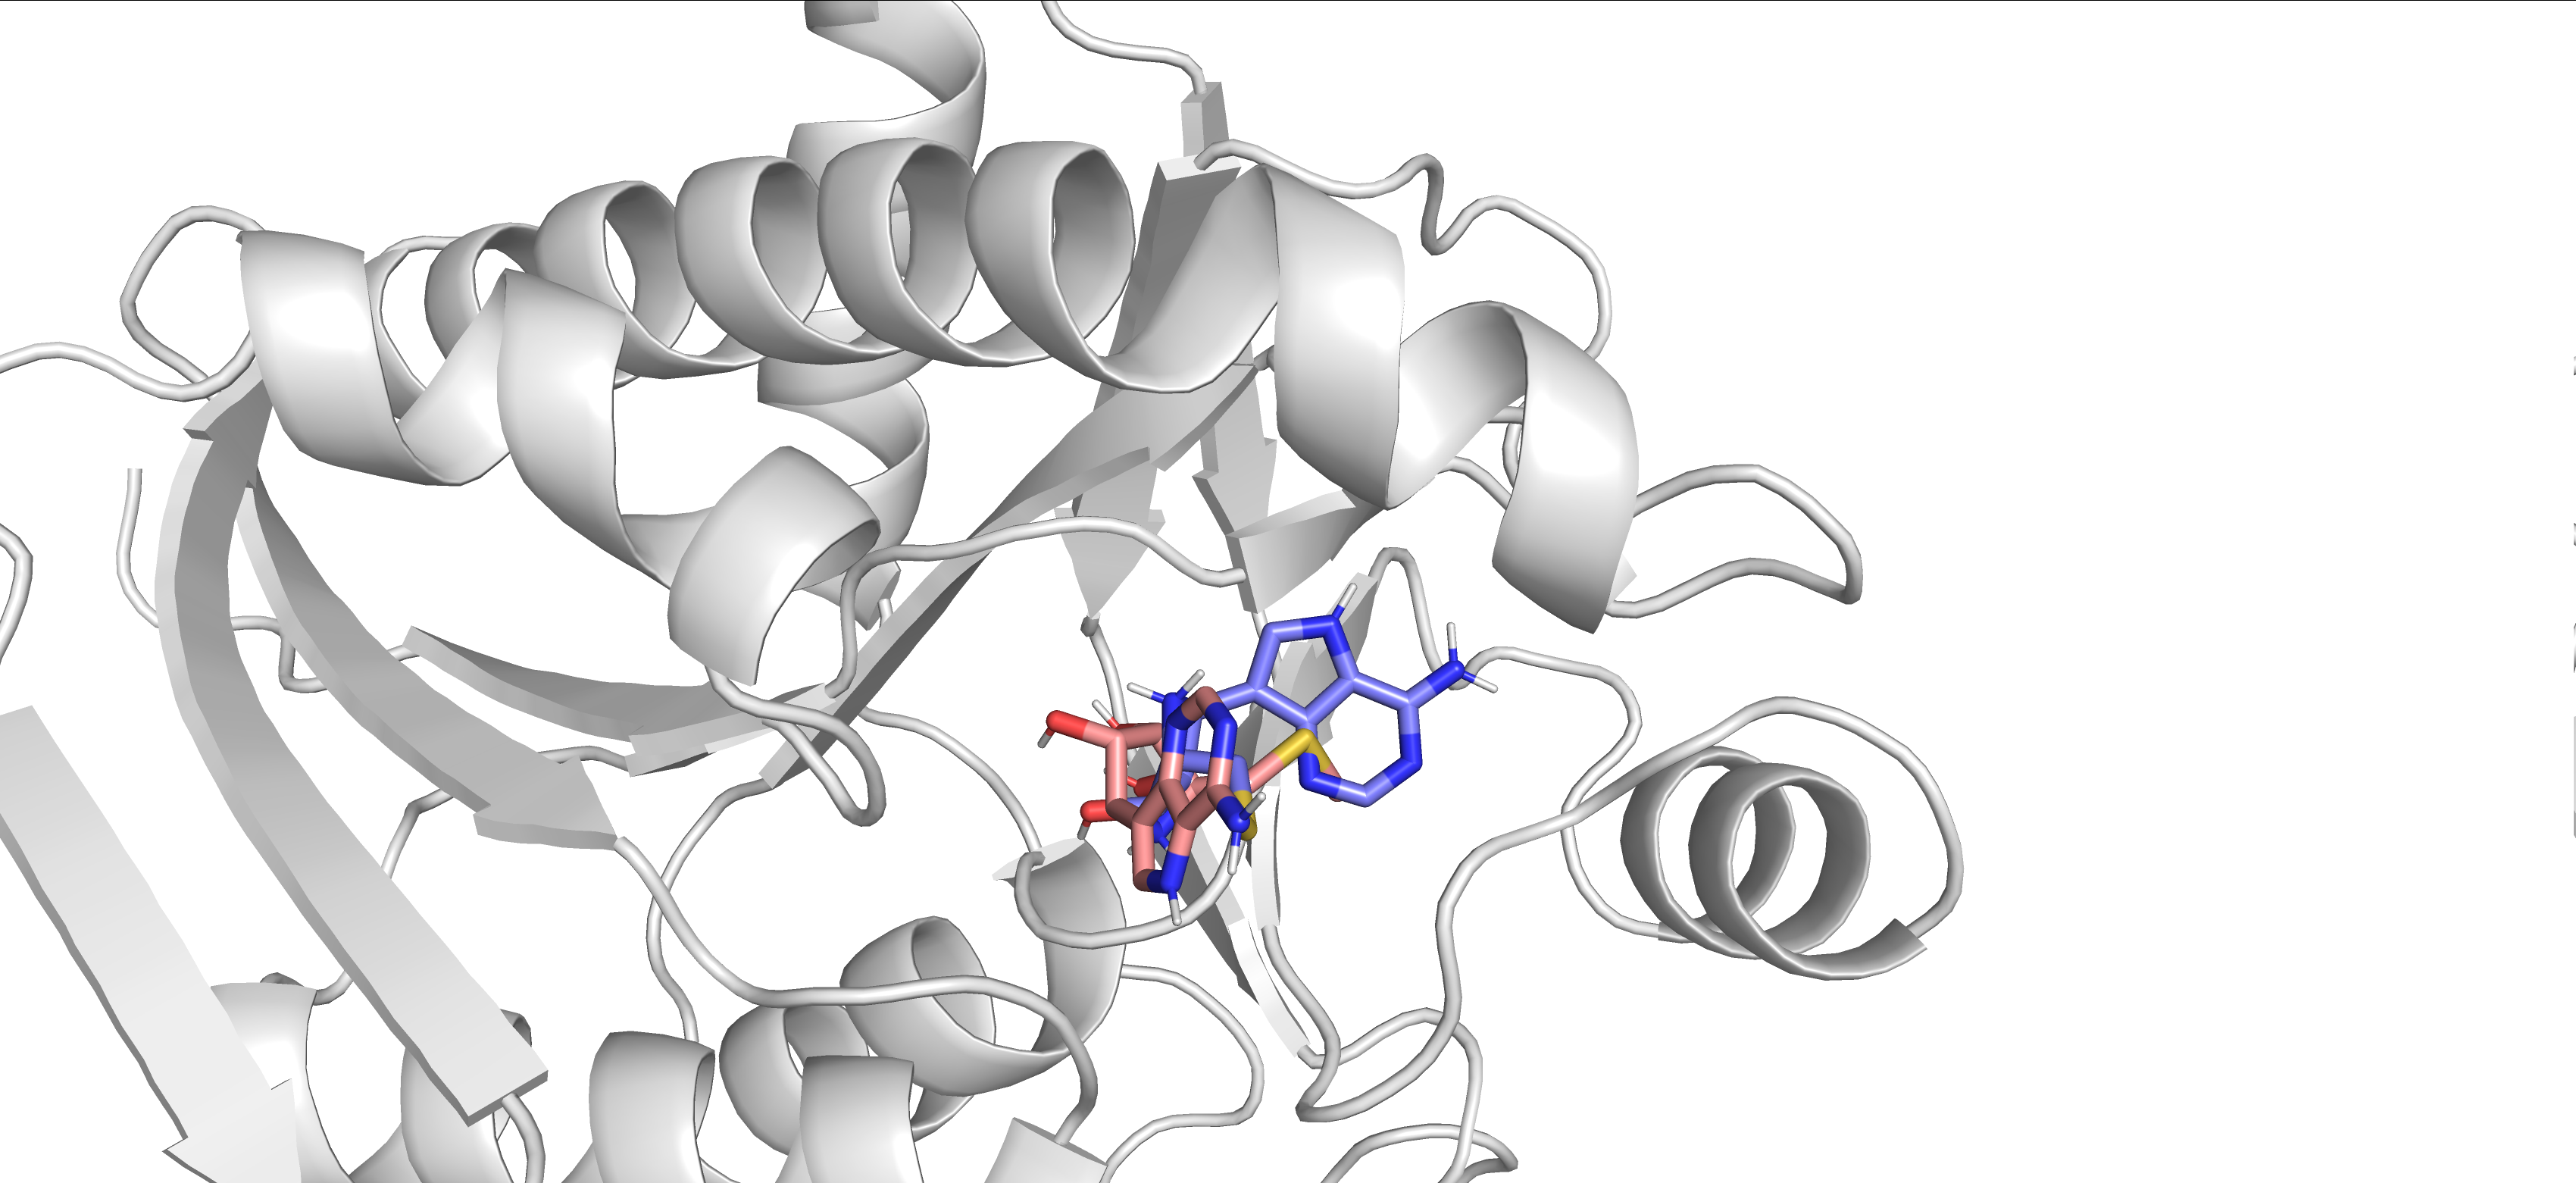
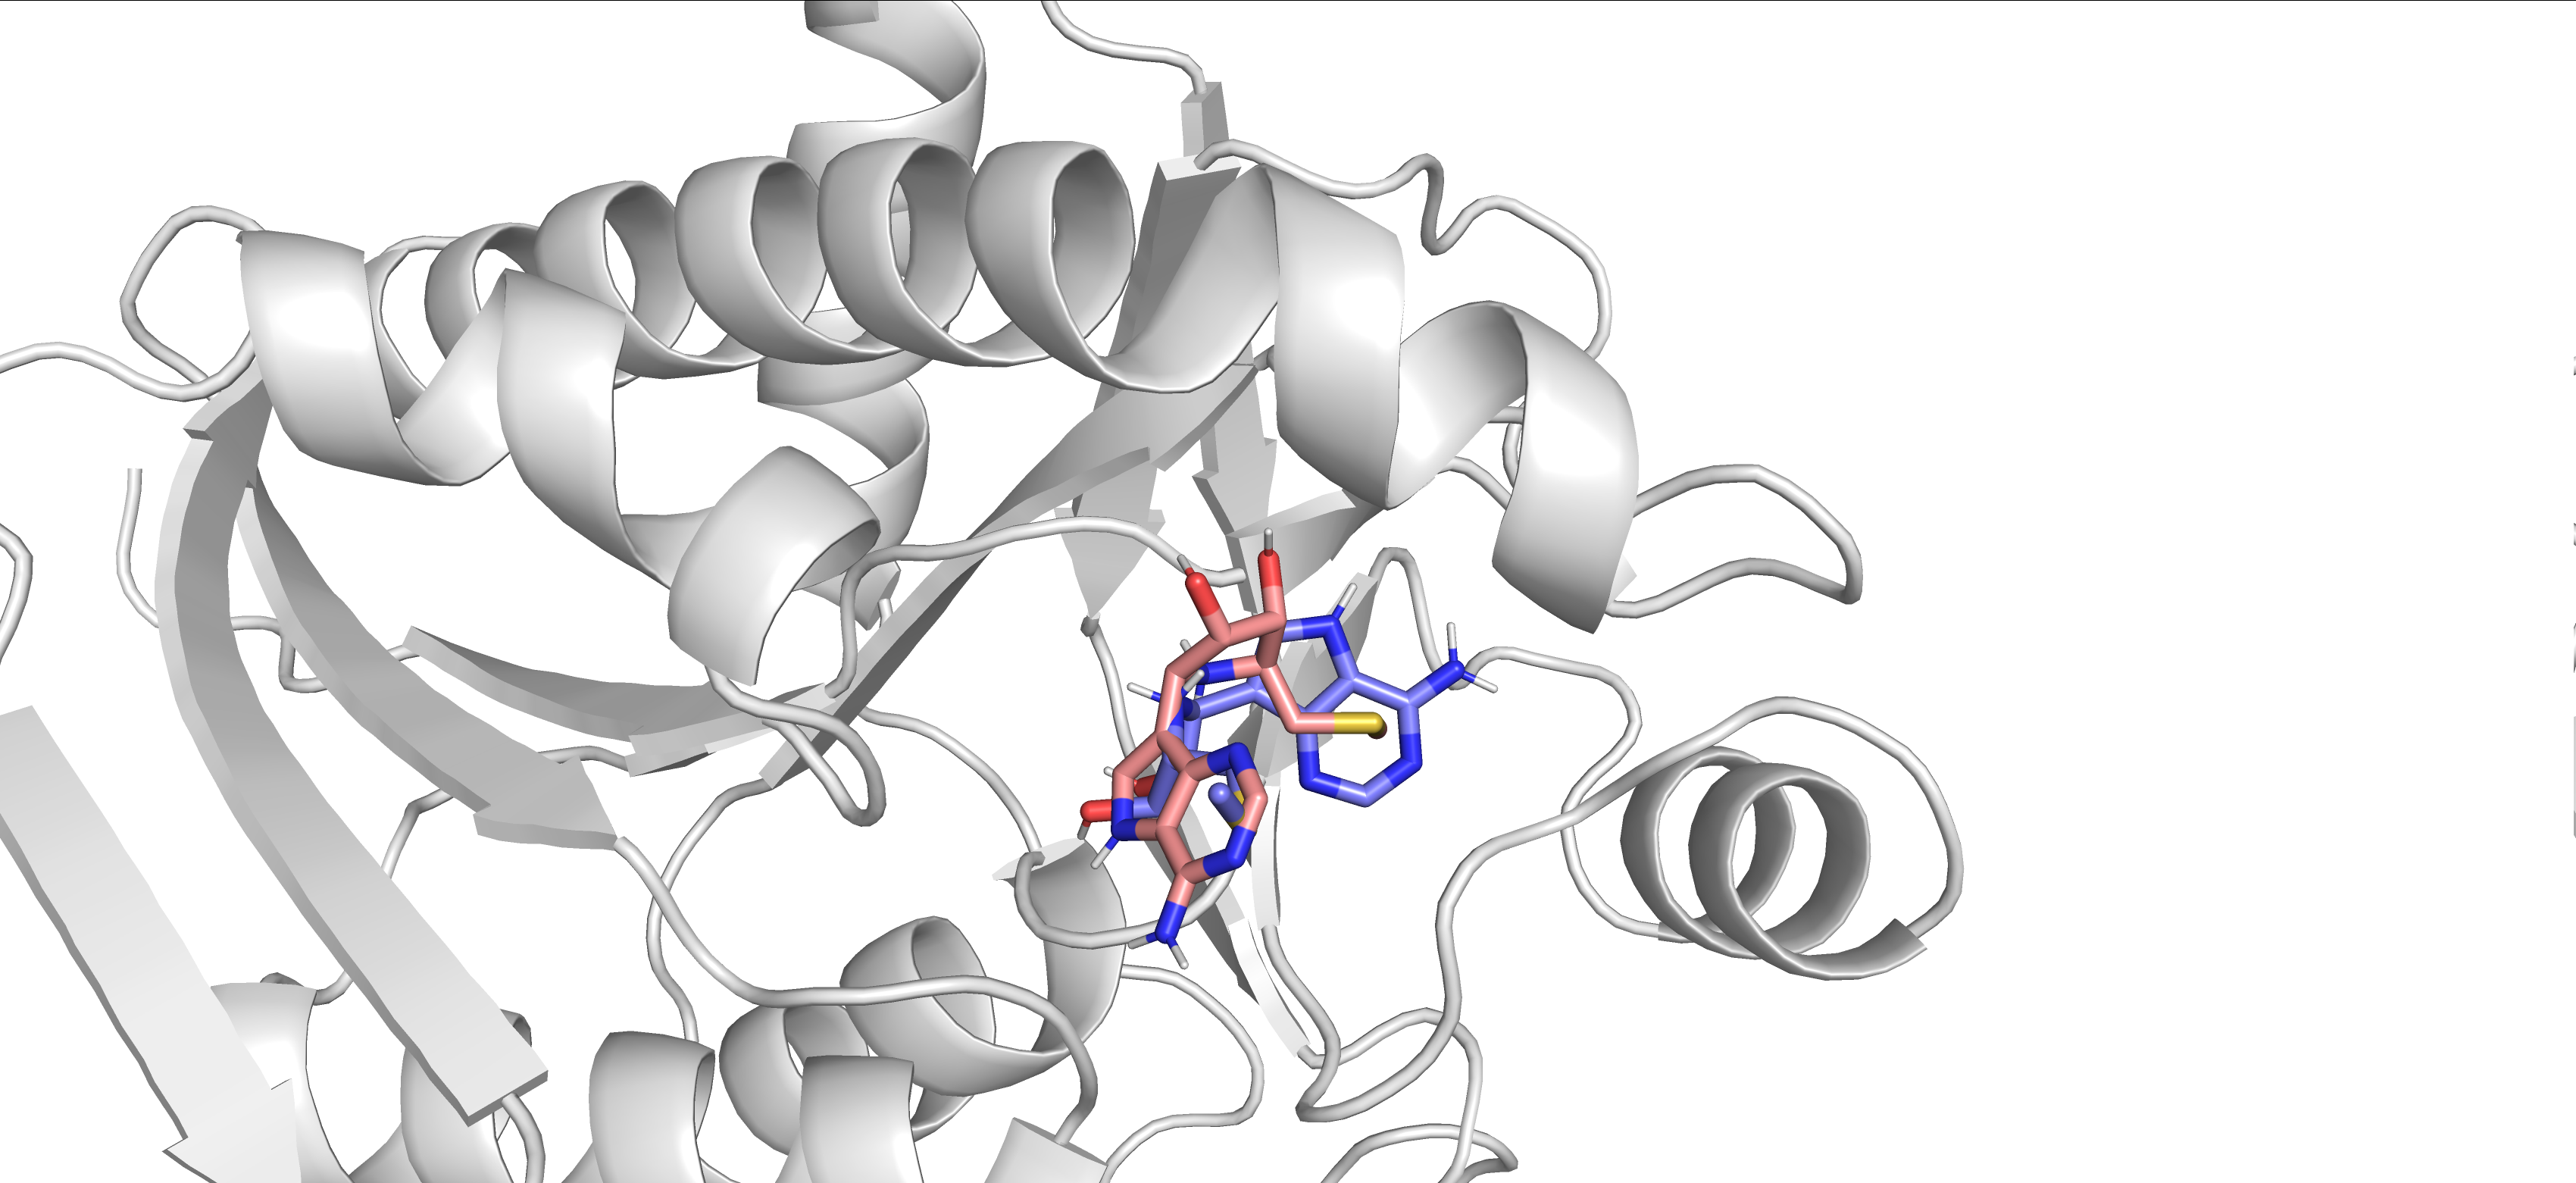

The way to use Grid Point Matching is almost the same as Feature Atom Matching

In [ ]:
os.chdir("%s/workdir_gpm"%(here))
import shutil

gpm = GPMDock()

print("Loading receptor and ligands...")
gpm.make_receptor("../data/1y6r_protein.pdb")

ligand_li = [
  "1y6r_ligand.mol2",
  "2vkm_ligand.mol2",
  "3dxg_ligand.mol2",
  "2iwx_ligand.mol2",   
]
for i in ligand_li:
    shutil.copy("%s/%s"%("../data",i),"./%s"%(i))
gpm.make_ligand(ligand_li)

print("Creating docking box...")
gpm.make_box_ligand("data/1y6r_ligand.mol2",grid_length=2.0)
#gpm.make_box_input(x=56.217,y=73.499,z=20.476,dx=10,dy=10,dz=10,grid_length=2.0)

print("Docking a single ligand...")
poses1 = gpm.indiv_dock(ligand=fam.ligands[0], edge_cutoff=2.162, K_dist=0.405, K_mono=25.090, n_pos=30, 
                       save_qubo=True,sim_dock=True,save_match=True,save_pose=True)
print("Docking all ligands...")
poses2 = gpm.dock(edge_cutoff=2.162, K_dist=0.405, K_mono=25.090, n_pos=30, 
                       save_qubo=True,sim_dock=True,save_match=True,save_pose=True)

print(type(poses1))
print(poses1.shape)
print(poses1[0])
print(type(poses2))
print(len(poses2))
print(poses2[1].shape)

import numpy as np
qubo = np.load("QUBOs/1y6r_ligand.npy",allow_pickle=True).item()
print(list(qubo.keys())[0:10])
print(qubo[list(qubo.keys())[0]])